In [ ]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel hydraulic conductance at end |

Velocity units: $$\frac{\text{m}^2}{\text{Pa} \cdot s} \times \left(\frac{d(\text{Pa})}{d \text{m}}\right) = \frac{\text{m}}{\text{s}}$$

In [2]:
%load_ext autoreload
%autoreload 2

In [28]:
import sys, os
import numpy as np
from graphnics import FenicsGraph

WORK_PATH = "/root/3d-1d"
SOURCE_PATH = os.path.join(WORK_PATH, 'src')
sys.path.append(SOURCE_PATH)

import tissue, fem, visualize

TEST_GRAPH_NODES = {
    0: [0.01, 0.020, 0.020],
    1: [0.02, 0.020, 0.020],
    2: [0.03, 0.020, 0.020],
    3: [0.04, 0.020, 0.020]
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.003),
    (1, 2, 0.003),
    (2, 3, 0.003)
]

import tissue, fem, visualize

TEST_GRAPH = FenicsGraph()

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

mesh_builder = tissue.MeshBuild(
    TEST_GRAPH,
    Omega_bounds= np.array([[0,0,0],[0.05, 0.04, 0.04]]),
    Omega_mesh_voxel_dim=(16, 16, 16),
    Lambda_num_nodes_exp=4
)

sink_face = mesh_builder.get_Omega_axis_plane("left")

measure_builder = tissue.DomainBuild(
    mesh_build=mesh_builder,
    Lambda_inlet=[0],
    Omega_sink=sink_face
)

_pos = np.array(TEST_GRAPH.nodes[3]['pos'])
_offset = np.array([0.01, 0.01, 0.01])
_upper_cube_bounds_val = [_pos - _offset, _pos + _offset]

CUBES_TEST = fem.SubCubes(
    domain = measure_builder,
    gamma = 1.0e-3,
    gamma_R = 1.0e-2,
    gamma_a = 1.0e-15,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.0e-10, # Vessel permeability in 1D
    P_in = 100 * 133.322,
    p_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.001, 0, 0],[0.005, 0.04, 0.04]],
    upper_cube_bounds = _upper_cube_bounds_val
)

CUBES_TEST.print_cube_diagnostics()

Averaging over 48 cells: 100%|██████████| 48/48 [00:00<00:00, 2530.09it/s]


Total Outflow (m^3/s): 3.988378043965143e-05
Total Outflow (m^3/s): 3.988378043965138e-05
------------------------
Net flux through lower: 1.843334795215489e-06
Inflow through lower: 0.0
Outflow through lower: 1.843334795215489e-06
------------------------
Net flux through upper: -1.843334795215473e-06
Inflow through upper: -1.843334795215473e-06
Outflow through upper: 0.0


Lower Cube Bounds: [[0.001, 0, 0], [0.005, 0.04, 0.04]]
Upper Cube Bounds: [array([0.03, 0.01, 0.01]), array([0.05, 0.03, 0.03])]


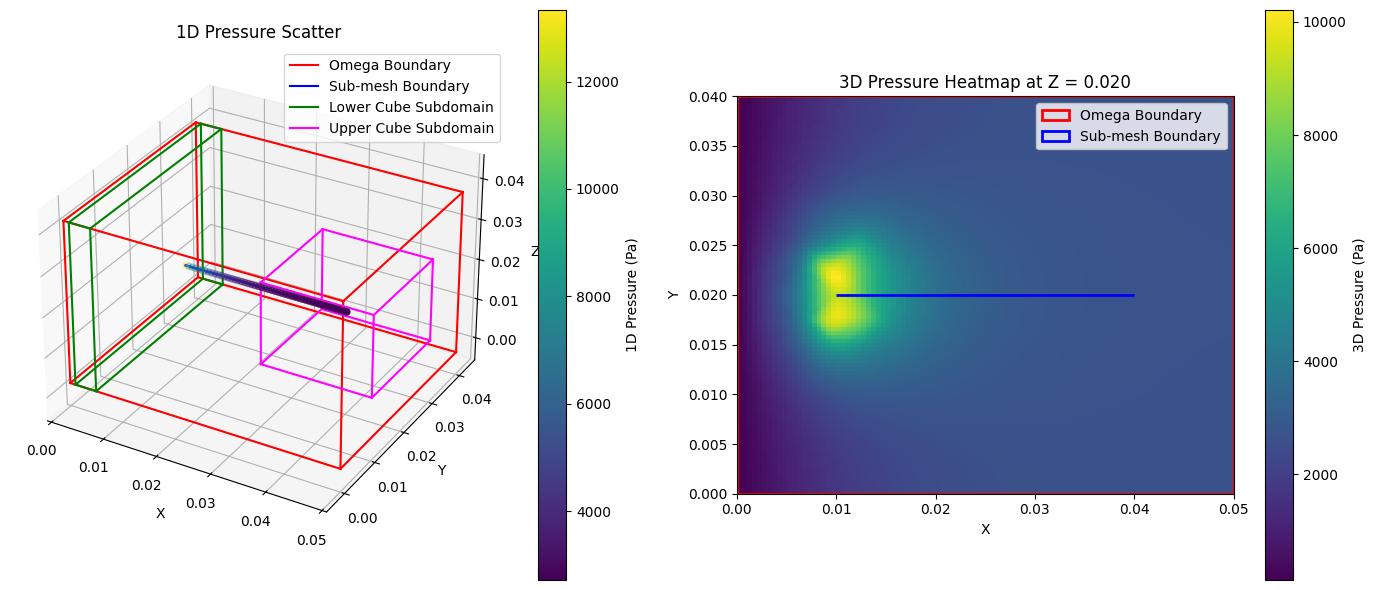

In [25]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)
fig1.show()

In [26]:
CUBES_TEST.print_diagnostics()

Flow Diagnostics
--------------------------------------------------
Sink Boundary:
  Inflow               : 0
  Outflow              : 3.988378e-05
  Net Flow (sum)       : 3.988378e-05
  Net Flow (Dolfin)    : 3.988378e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Neumann Boundary:
  Net Flow (Dolfin)    : 1.6146902e-20
--------------------------------------------------
Entire Domain Boundary:
  Inflow               : -1.8433348e-06
  Outflow              : 4.1727115e-05
  Net Flow (sum)       : 3.988378e-05
  Net Flow (Dolfin)    : 3.988378e-05
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Sum of dsOmegaNeumann and dsOmegaSink (Dolfin):
  Neumann + Sink       : 3.988378e-05
  --> This should match the net flow over the entire domain boundary.
--------------------------------------------------


Node Pressure Data:
Node 0: Pressure 13332.2
Node 25: Pressure 9094.5
Node 13: Pressure 8073.0
Node 26: Pressure 7594.4
Node 7: Pressure 7214.8
Node 28: Pressure 6814.5
Node 14: Pressure 6336.8
Node 27: Pressure 5842.0
Node 4: Pressure 5389.9
Node 31: Pressure 5058.2
Node 16: Pressure 4821.7
Node 32: Pressure 4596.9
Node 8: Pressure 4369.3
Node 30: Pressure 4155.5
Node 15: Pressure 3985.2
Node 29: Pressure 3861.9
Node 1: Pressure 3745.1
Node 33: Pressure 3627.4
Node 17: Pressure 3515.7
Node 34: Pressure 3423.5
Node 9: Pressure 3355.3
Node 36: Pressure 3291.2
Node 18: Pressure 3226.8
Node 35: Pressure 3165.3
Node 5: Pressure 3113.5
Node 39: Pressure 3074.5
Node 20: Pressure 3038.1
Node 40: Pressure 3001.6
Node 10: Pressure 2966.5
Node 38: Pressure 2936.6
Node 19: Pressure 2913.9
Node 37: Pressure 2892.7
Node 2: Pressure 2871.5
Node 41: Pressure 2851.0
Node 21: Pressure 2833.5
Node 42: Pressure 2820.1
Node 11: Pressure 2807.5
Node 44: Pressure 2795.0
Node 22: Pressure 2783.0
Node 43: Pre

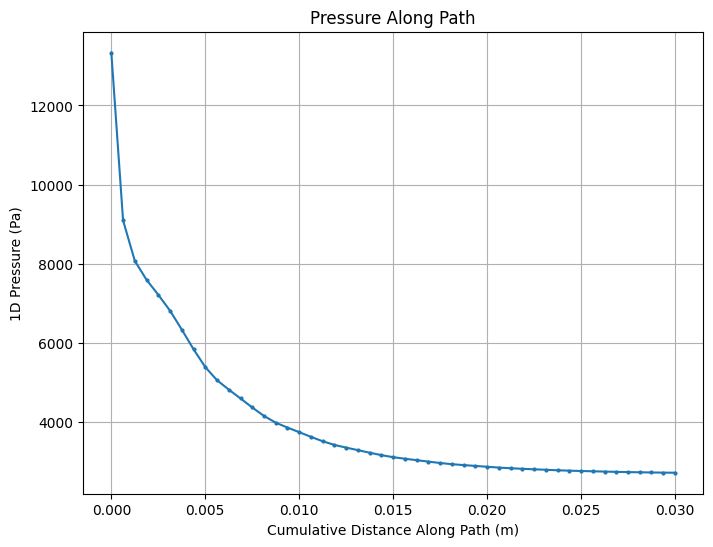

In [23]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 2, 3])
fig1.show()

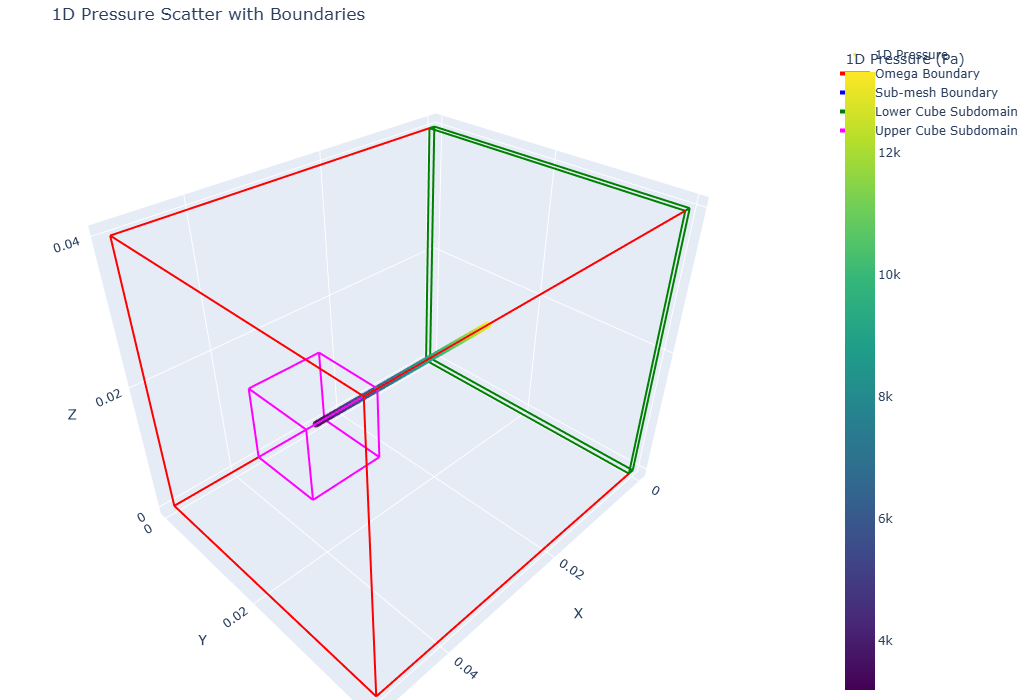

In [34]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [10]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"straightline_output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)